In [1]:
#Importing the libraries
import numpy as np
import pandas as pd
import os
import cv2
import time
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, precision_score 
from sklearn.metrics import recall_score, average_precision_score, auc

import imblearn
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

/Users/nbhadra/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv('creditcard.csv') ## https://www.kaggle.com/mlg-ulb/creditcardfraud
df = data.copy()

In [3]:
#pwd

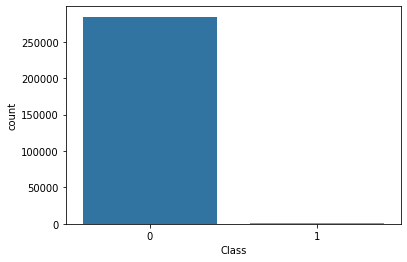

In [4]:
sns.countplot(df['Class'])


In [5]:
df['norm_amount'] = StandardScaler().fit_transform(np.array(df['Amount']).reshape(-1,1))
df['norm_time'] = StandardScaler().fit_transform(np.array(df['Time']).reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)
X = df.copy() 
X.drop(['Class'], axis=1, inplace=True) 
y = df.loc[:,'Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
print("Training data count of 0={}, count of 1={}".format(sum(y_train==0), sum(y_train==1)))
print("Testing data count of 0={}, count of 1={}".format(sum(y_test==0), sum(y_test==1)))

Training data count of 0=227454, count of 1=391
Testing data count of 0=56861, count of 1=101


In [7]:
classifier = lgb.LGBMClassifier(objective='binary', random_state=0, n_jobs=-1)
classifier.fit(X_train, y_train)
ypred = classifier.predict(X_test)

In [8]:
kf = KFold(n_splits=10, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0)
rs_parameters = {
    'lgbmclassifier__learning_rate': [0.005,0.01,0.001,0.05],
    'lgbmclassifier__n_estimators': [20,40,60,80,100],
    'lgbmclassifier__num_leaves': [6,8,12,16]
    }
smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kf,
                         scoring='roc_auc',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train, y_train)
bestimator = grid_imba.best_estimator_
ypred = bestimator.predict(X_test)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/nbhadra/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 44.9min finished


In [11]:
confusion_matrix(y_test, ypred)

array([[56346,   515],
       [   11,    90]])